In [152]:
import copy
from math import atan2
import numpy as np
from tqdm import tqdm, trange

----

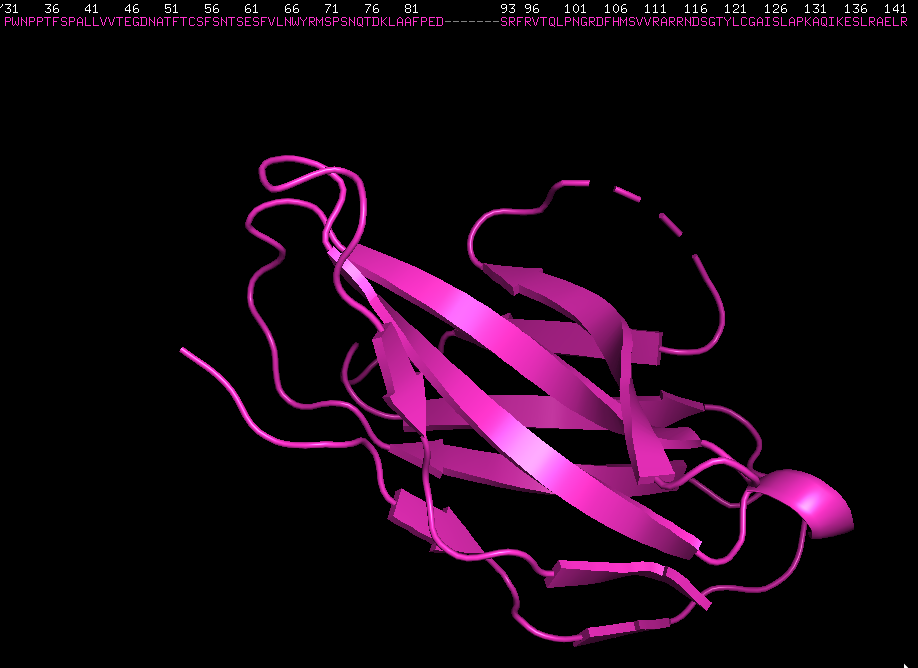

In [155]:
from IPython.display import Image, display
display(Image('img/pymol_view_protein_with_gap.png'))

## 1. Get sequence from fasta without eyeballing it

In [156]:
from Bio import SeqIO
pdbfile = 'hw_3_hole.pdb'
with open(pdbfile, 'r') as handle:
    seq = next(SeqIO.parse(handle, "pdb-atom")).seq

gap_start = gap_end = None
print(seq)
for i, aa in enumerate(seq):
    if aa == 'X':
        gap_start = i
        gap_end = i
        while seq[i] == 'X':
            gap_end += 1
            i += 1
        break
    
fastafile= 'PD1.fasta'
with open(fastafile, 'r')  as handle:
    complete_seq = next(SeqIO.parse(handle, 'fasta')).seq
    

seq_gap = seq[gap_start - 1:gap_end + 1]
seq_gap_filled = complete_seq[gap_start - 1:gap_end + 1]
print(seq_gap)
print(seq_gap_filled)

PWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTDKLAAFPEDXXXXXXXSRFRVTQLPNGRDFHMSVVRARRNDSGTYLCGAISLAPKAQIKESLRAELR
DXXXXXXXS
DRSQPGQDS


/home/iam28th/miniconda3/envs/biopython/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Atom H defined twice in residue <Residue SER het=  resseq=93 icode= > at line 1310.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(


## 2. Generate some initial loop from sequence
using https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb


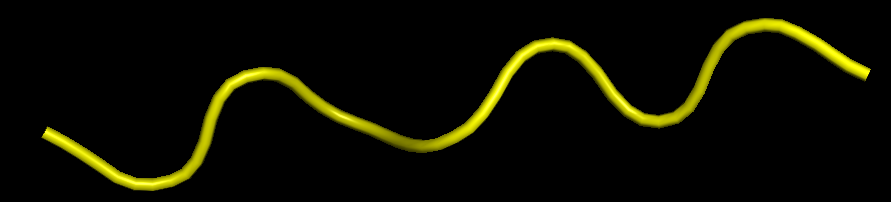

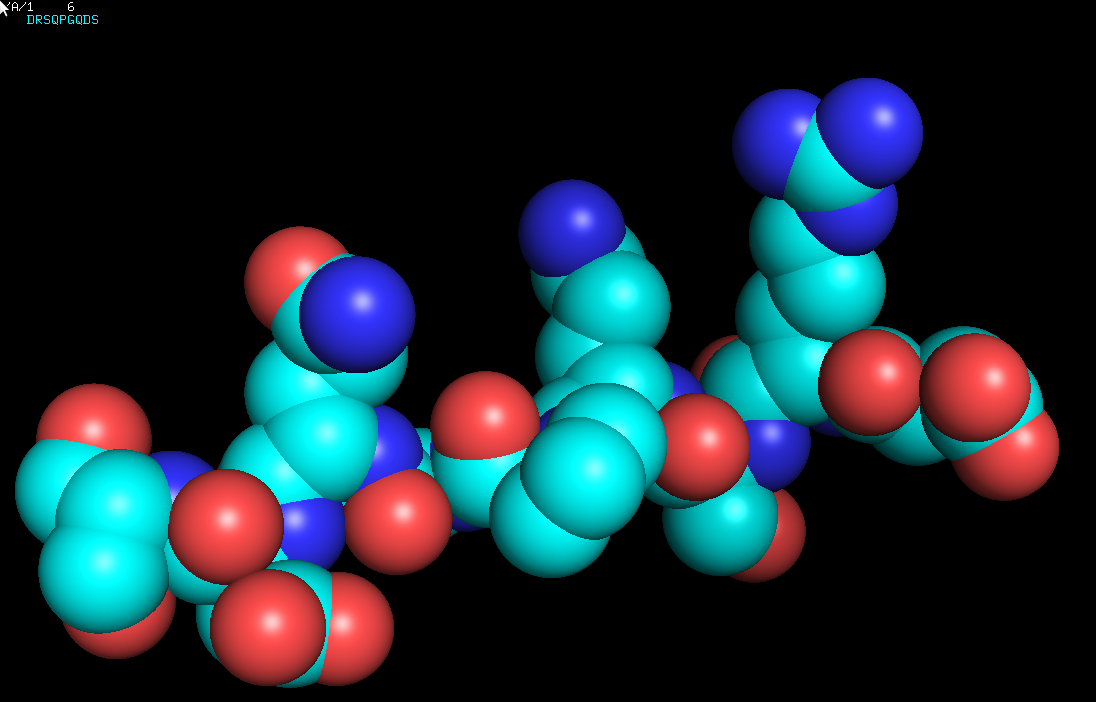

In [157]:
display(Image('img/pymol_view_init_stick.png'))
display(Image('img/pymol_view_init.png'))

Does not look like this structure would fit into the original protein.

## 3. The anchors

the left anchor - `C` atom of `D`.

the right anchor - `N` atom of `S`.

maybe try to look only on `D` and `S` in pdb? and then try to align 

In [158]:
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser(PERMISSIVE=1)  # ignore some PDB specification problems
structure_id = "hw_3"
filename = "hw_3_hole.pdb"

struct = parser.get_structure(structure_id, filename)

residues = list(struct.get_residues())
res_left = residues[gap_start-1]
res_right = residues[gap_start]
# D - Aspsraric Acid (Asp)
# S - Serine (Ser)
print(res_left, res_right)

def get_backbone_atoms(res):
    atoms = res.get_atoms()
    N = next(atoms)
    Ca = next(atoms)
    C = next(atoms)
    return [N, Ca, C]

left_anchor = get_backbone_atoms(res_left)[2].get_coord()  # 'C' atom of D
right_anchor = get_backbone_atoms(res_right)[0].get_coord()  # 'N' atom of S
print('Coordinates of the left anchor:', left_anchor)  
print('Coordinates of the right anchor:', right_anchor)  

<Residue ASP het=  resseq=85 icode= > <Residue SER het=  resseq=93 icode= >
Coordinates of the left anchor: [ 18.749 -22.592 -12.492]
Coordinates of the right anchor: [ 16.03  -32.644 -15.111]


/home/iam28th/miniconda3/envs/biopython/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Atom H defined twice in residue <Residue SER het=  resseq=93 icode= > at line 1310.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(


## 4. Align initial structure (generated in p2) to the left anchor by the first atom

In [159]:
from Bio.PDB.PDBParser import PDBParser
parser = PDBParser(PERMISSIVE=1)  # ignore some PDB specification problems
structure_id = "ils"
filename = "initial_loop_structure.pdb"

ils = parser.get_structure(structure_id, filename)
from Bio.PDB.vectors import Vector, rotmat

res = next(ils.get_residues())

def calc_centroid(atms):
    centr = np.zeros(3)
    for a in atms:
        centr += a.get_coord()
    return centr / len(atms)

def aligning_transforms(res_fixed, res_moving):   
    res_fixed = copy.deepcopy(res_fixed)
    res_moving = copy.deepcopy(res_moving)
    
    atm_fixed = get_backbone_atoms(res_fixed)
    atm_moving = get_backbone_atoms(res_moving)
    r = np.eye(3)
    c_fixed = calc_centroid(atm_fixed)
    for i in range(3):
        c_moving = calc_centroid(atm_moving)
        vec_fixed = Vector(atm_fixed[i].get_coord() - c_fixed)
        vec_moving = Vector(atm_moving[i].get_coord() - c_moving)
        rot = rotmat(vec_fixed, vec_moving)
        r = r @ rot
        res_moving.transform(rot, np.zeros(3))
    c_moving = calc_centroid(atm_moving)
    trans = c_fixed - c_moving
    return r, trans

r, trans = aligning_transforms(res_left, res)


ils.transform(r, trans)

In [160]:
from Bio.PDB import PDBIO

io = PDBIO()
io.set_structure(ils)
io.save("initial_loop_structure_aligned.pdb" )

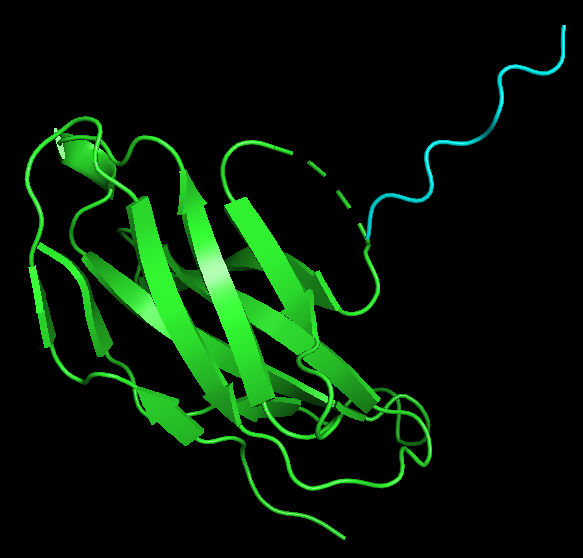

In [161]:
display(Image('img/pymol_view_init_aligned.png'))

## 5. Implementation - CA only
but the first rotation will be aroung N-CA bond of the left anchor... 

Then we will minimize only $S = d_1 = dist(C\alpha_{final}, C\alpha_{current})$

In [162]:
def find_footpoint(M, C1, C2):  
    """
        finds projection of M onto C1-C2 axis
    """
    cvec = C2 - C1
    cvec /= np.linalg.norm(cvec)
    
    v = M - C1
    t = v.dot(cvec)
    return C1 + t * cvec

def dist(x, y):
    return np.linalg.norm(x - y)

In [163]:
print(find_footpoint(np.array([2, 2, 0]), np.zeros(3), np.ones(3)))
print(find_footpoint(np.array([1, 1, 1]), np.zeros(3), np.array([0, 1, 0])))

[1.33333333 1.33333333 1.33333333]
[0. 1. 0.]


In [164]:
def print_dists():
    """
        prints current distance between adjacent CA atoms
    """
    n = len(CAs)
    for i in range(1, n):
        print(dist(CAs[i], CAs[i-1]))

In [165]:
parser = PDBParser(PERMISSIVE=1)  # ignore some PDB specification problems
structure_id = "ils"
filename = "initial_loop_structure_aligned.pdb"
ils = parser.get_structure(structure_id, filename)

res_lst = list(ils.get_residues())
CAs = [list(res.get_atoms())[1].get_coord() for res in res_lst]
CAs_backup = copy.deepcopy(CAs)
n = len(CAs)

F = copy.deepcopy(list(res_right.get_atoms())[1].get_coord())

flag = False
EPS = 1

print('initial dist:')
print(dist(F, CAs[-1]))

print('=' * 10)
print('Sanity check - distance between neighboring atoms should not change')
print_dists()
niter = 1000
vals = []
for t in trange(niter):
    for cur in range(-1, n - 2):
        if cur == -1:
            C1, C2 = [a.get_coord() for a in list(res_lst[0].get_atoms())[:2]]
            assert np.all(C2 == CAs[0])
        else:
            C1 = CAs[cur]
            C2 = CAs[cur + 1]
    
        M = CAs[-1]    # moving Ca current coordinates

        cvec = (C2 - C1)  #  vector, collinear to axis
                          #  parametric axis equation:  C1 + t * cvec

        O = find_footpoint(M, C1, C2)
        f = F - O
        r = M - O
        # assert np.dot(r, cvec) < 1e-5

        # define local orthogonal coordinates
        r_ort = r / np.linalg.norm(r)
        theta_ort = cvec / np.linalg.norm(cvec)
        s_ort = np.cross(r_ort, theta_ort)

        # d = S := a - b \cos \theta - c \sin \theta
        # a = np.sum(r**2) + np.sum(f**2) (is not actually needed)
        b = 2 * np.linalg.norm(r) * np.dot(f, r_ort)
        c = 2 * np.linalg.norm(r) * np.dot(f, s_ort)

        cosa = b / np.sqrt(b**2 + c**2)
        sina = c / np.sqrt(b**2 + c**2)
        theta = atan2(cosa, sina)
        

        if cur == -1:
            start = 1
        else:
            start = cur + 2
        for i in range(start, n):
            M = CAs[i]
            O = find_footpoint(M, C1, C2)
            
            r = M - O
            
            r_ort = r / np.linalg.norm(r)
            s_ort = np.cross(r_ort, theta_ort)
            
            r = np.linalg.norm(r)
            OM1 = r * np.cos(theta) * r_ort + r * np.sin(theta) * s_ort
            CAs[i] = O + OM1
        aft = dist(CAs[-1], F)
        if np.isnan(aft):
            flag = True
            break
        if abs(aft) < EPS:
            flag = True
            break
    if flag:
        break
        
print('=' * 10)
print_dists()
print('=' * 10)
print(aft, flag)

initial dist:
25.298056
Sanity check - distance between neighboring atoms should not change
3.601567
3.805469
3.8095691
3.841734
3.7567546
3.7395935
3.7094579
3.8399353


 17%|████████████████                                                                               | 169/1000 [00:00<00:02, 364.14it/s]

3.6015759
3.8054981
3.8095684
3.8417552
3.7567766
3.7396424
3.7094505
3.839896
0.6865918 True


## 6. Make `.pdb` with new CA positons

In [166]:
from Bio.PDB.PDBIO import Select

rot = copy.deepcopy(ils)

class BBSelect(Select):
    def accept_atom(self, a):
        return a.get_name() == 'CA'
        
io_res = PDBIO()
io_res.set_structure(rot)
io_res.save("ils_aligned_backbone.pdb", BBSelect())

In [167]:
parser = PDBParser(PERMISSIVE=1)  # ignore some PDB specification problems
structure_id = "ils"
filename = "ils_aligned_backbone.pdb"

ils = parser.get_structure(structure_id, filename)

In [168]:
rot = copy.deepcopy(ils)

for CA, res in zip(CAs, rot.get_residues()):
    CA_atom = next(res.get_atoms())
    CA_atom.set_coord(CA)

In [169]:
io = PDBIO()
io.set_structure(rot)
io.save("rotated_loop.pdb" )

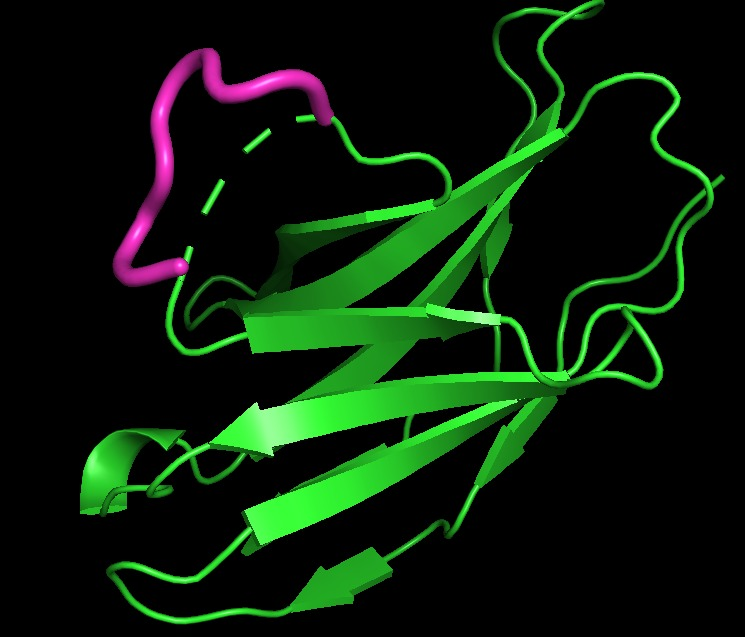

In [170]:
display(Image("img/pymol_view_rotated_loop.png"))

...close enough

## 7. merge together with initial structure into a single PDB

add this lines from `rotated_loop.pdb` to the end of the original file 
```
ATOM   2002  CA  ARG A  86      18.744 -22.272  -9.872  1.00 62.94           C
ATOM   2003  CA  SER A  87      15.939 -24.816  -9.495  1.00 78.21           C
ATOM   2004  CA  GLN A  88      13.436 -22.487 -11.175  1.00 73.07           C
ATOM   2005  CA  PRO A  89      11.772 -24.807 -13.746  1.00 68.66           C
ATOM   2006  CA  GLY A  90      13.636 -28.057 -14.015  1.00 78.97           C
ATOM   2007  CA  GLN A  91      12.898 -29.829 -17.224  1.00 72.24           C
ATOM   2008  CA  ASP A  92      13.788 -33.240 -16.070  1.00 72.64           C
```

## 8. more colors!

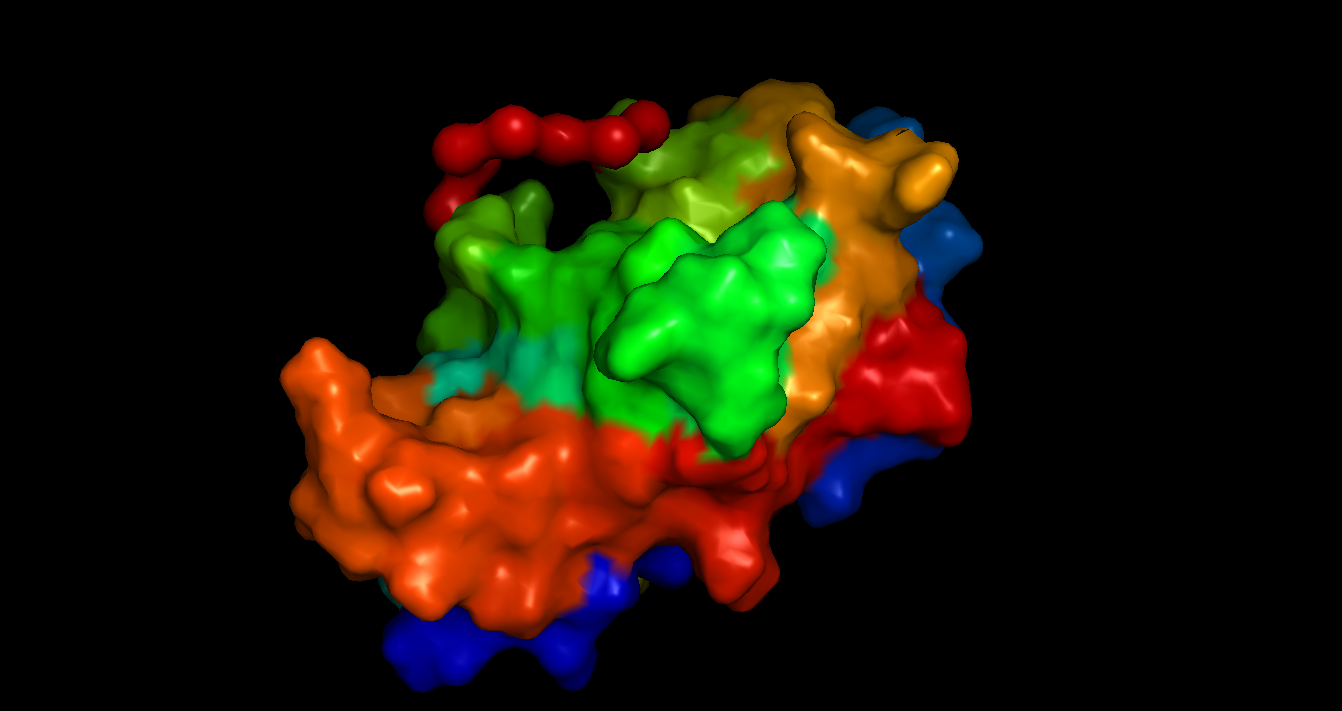

In [171]:
display(Image('img/pymol_view_final_colors.png'))